# Compare MS2DeepScore trained on different fingerprints

In [1]:
import os
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from ms2deepscore import SpectrumBinner
from ms2deepscore.models import SiameseModel

path_root = os.path.dirname(os.path.dirname(os.getcwd()))
path_data = os.path.join(path_root, 'Data')
path_models = os.path.join(path_root, 'SURF_model_training_runs')

## Additional plotting function

In [2]:
def precision_recall_plot(scores_test, scores_ref,
                          high_sim_threshold=0.6,
                          n_bins = 20):
    """Basic precision recall plot"""
    precisions = []
    recalls = []

    above_thres_total = np.sum(scores_ref >= high_sim_threshold)
    max_score = scores_test.max()
    min_score = scores_test.min()
    score_thresholds = np.linspace(min_score, max_score, n_bins+1)
    for low in score_thresholds:
        idx = np.where(scores_test>=low)
        above_thres = np.sum(scores_ref[idx] >= high_sim_threshold)
        below_thres = np.sum(scores_ref[idx] < high_sim_threshold)

        precisions.append(above_thres/(below_thres+above_thres))
        recalls.append(above_thres/above_thres_total)

    plt.figure(figsize=(6,5), dpi=120)
    plt.plot(recalls, precisions, "o--", color="crimson", label="precision/recall")
    #plt.plot(score_thresholds, precisions, "o--", color="crimson", label="precision")
    #plt.plot(score_thresholds, recalls, "o--", color="dodgerblue", label="recall")
    plt.legend()
    plt.xlabel("recall", fontsize=12)
    plt.ylabel("precision", fontsize=12)
    plt.title(f"precision/recall (high-similarity if Tanimoto > {high_sim_threshold })")
    plt.grid(True)
    
    return precisions, recalls

In [3]:
def tanimoto_dependent_losses(scores, scores_ref, ref_score_bins):
    bin_content = []
    rmses = []
    maes = []
    bounds = []
    ref_scores_bins_inclusive = ref_score_bins.copy()
    ref_scores_bins_inclusive[0] = -np.inf
    ref_scores_bins_inclusive[-1] = np.inf
    for i in range(len(ref_scores_bins_inclusive)-1):
        low = ref_scores_bins_inclusive[i]
        high = ref_scores_bins_inclusive[i+1]
        bounds.append((low, high))
        idx = np.where((scores_ref >= low) & (scores_ref < high))
        bin_content.append(idx[0].shape[0])
        maes.append(np.abs(scores_ref[idx] - scores[idx]).mean())
        rmses.append(np.sqrt(np.square(scores_ref[idx] - scores[idx]).mean()))

    return bin_content, bounds, rmses, maes


def plot_tanimoto_dependent_losses(bin_content, bounds, rmses, maes):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6, 8), dpi=120)
    ax1.plot(np.arange(len(rmses)), maes, "o--")
    ax1.set_title('MAE')
    ax1.set_ylabel("MAE")
    #ax1.set_ylim(0)
    ax1.grid(True)
    
    ax2.plot(np.arange(len(rmses)), rmses, "o--", color="crimson")
    ax2.set_title('RMSE')
    ax2.set_ylabel("RMSE")
    #ax2.set_xlabel("score STD threshold")
    #ax2.set_ylim(0)
    ax2.grid(True)

    ax3.plot(np.arange(len(rmses)), bin_content, "o--", color="teal")
    ax3.set_title('# of spectrum pairs')
    ax3.set_ylabel("# of spectrum pairs")
    ax3.set_xlabel("Tanimoto score bin")
    plt.xticks(np.arange(len(rmses)),
               [f"{a:.1f} to < {b:.1f}" for (a, b) in bounds], fontsize=9, rotation='vertical')
    #ax3.set_ylim(0)
    ax3.grid(True)
    

def tanimoto_dependent_STDs(scores_STD, scores_ref, bins):
    bin_content = []
    STDs = []
    for i in range(len(ref_score_bins)-1):
        low = ref_score_bins[i]
        high = ref_score_bins[i+1]
        idx = np.where((scores_ref >= low) & (scores_ref < high))
        bin_content.append(idx[0].shape[0])
        STDs.append(scores_STD[idx].mean())
    return bin_content, STDs   

### Load Tanimoto scores (=labels) THIS TIME: using morgan3 fingerprints (2048bits)

In [7]:
filename = os.path.join(path_data, 'ALL_GNPS_210125_morgan3_2048_tanimoto_scores.pickle')
tanimoto_df = pd.read_pickle(filename)
tanimoto_df.head()

,JJGYRVZPUJUFTR,CSVWQRLFFUNUND,PXWNBAGCFUDYBE,DFJVUWAHTQPQCV,PNOLBYVRLYUCIC,HBNPJJILLOYFJU,IVKGLRZLTNXWKF,WHZAJDSPQDCUBB,LFVSQVHIKFDYFI,LBBJNGFCXDOYMQ,...,NBWDKCDWCBQNQQ,WKHWTIZYRUWECB,HYIFFZAQXPUEAU,GYOZYWVXFNDGLU,YNDYKPRNFWPPFU,IYODIJVWGPRBGQ,XHCADAYNFIFUHF,OJAGBDHRHPCDLN,POUZLUJYBWGJJO,JAYJEXYYCNLGOQ
JJGYRVZPUJUFTR,1.000000,0.077381,0.073684,0.054545,0.106383,0.105634,0.078947,0.066116,0.100917,0.075269,...,0.079365,0.094737,0.086957,0.116505,0.061224,0.020202,0.081818,0.105263,0.065934,0.085366
CSVWQRLFFUNUND,0.077381,1.000000,0.057692,0.078313,0.073529,0.094527,0.044944,0.066667,0.051724,0.058442,...,0.093407,0.030864,0.044872,0.078788,0.018293,0.078947,0.040000,0.071429,0.025641,0.080717
PXWNBAGCFUDYBE,0.073684,0.057692,1.000000,0.075269,0.068702,0.084615,0.126316,0.097087,0.094737,0.063291,...,0.111111,0.113924,0.090909,0.087912,0.086420,0.075949,0.084211,0.091667,0.109589,0.038462
DFJVUWAHTQPQCV,0.054545,0.078313,0.075269,1.000000,0.062069,0.068966,0.100000,0.058333,0.072727,0.053763,...,0.063492,0.073684,0.065217,0.066038,0.040816,0.042105,0.083333,0.074074,0.091954,0.066667
PNOLBYVRLYUCIC,0.106383,0.073529,0.068702,0.062069,1.000000,0.101695,0.087838,0.063694,0.089655,0.095238,...,0.234043,0.083969,0.053435,0.133333,0.059701,0.053030,0.207692,0.170886,0.062992,0.080000


## Import test data

In [4]:
import pickle
outfile = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_test_split_210301.pickle')
with open(outfile, 'rb') as file:
    spectrums_test = pickle.load(file)

print(f"{len(spectrums_test)} spectrums in test data.")

3601 spectrums in test data.


## Import pretrained model (20210402-125228_10k_800_800_200_morgan3.hdf5)
Model trained on morgan3 fingerprints.

In [6]:
# import spectrum binner
outfile = os.path.join(path_data, 'GNPS_all',
                       'ALL_GNPS_positive_training_spectrum_binner_210301_10k.pickle')
with open(outfile, 'rb') as file:
    spectrum_binner = pickle.load(file)  

In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model as load_keras_model
keras_model_file = os.path.join(path_models, "trained_models", "20210402-125228_10k_800_800_200_morgan3.hdf5")
keras_model = load_keras_model(keras_model_file)

In [8]:
model = SiameseModel(spectrum_binner, keras_model=keras_model)

In [9]:
model.base.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 9948)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 800)               7959200   
_________________________________________________________________
normalization1 (BatchNormali (None, 800)               3200      
_________________________________________________________________
dropout1 (Dropout)           (None, 800)               0         
_________________________________________________________________
dense2 (Dense)               (None, 800)               640800    
_________________________________________________________________
normalization2 (BatchNormali (None, 800)               3200      
_________________________________________________________________
dropout2 (Dropout)           (None, 800)               0      

## Predict Tanimoto scores

In [10]:
from ms2deepscore import MS2DeepScore
similarity_score = MS2DeepScore(model)

In [11]:
similarities_test = similarity_score.matrix(spectrums_test, spectrums_test, is_symmetric=True)

Calculating vectors of reference spectrums: 100%|██████████████████████████████████| 3601/3601 [05:13<00:00, 11.50it/s]


In [12]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_test_20210402-125228_10k_800_800_200_morgan3.npy")
np.save(predictions_file, similarities_test)

### Alternative (e.g. for re-runs): load pre-computed scores

In [4]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_test_20210402-125228_10k_800_800_200_morgan3.npy")
similarities_test = np.load(predictions_file)

In [13]:
inchikey_idx_test = np.zeros(len(spectrums_test))
for i, spec in enumerate(spectrums_test):
    inchikey_idx_test[i] = np.where(tanimoto_df.index.values == spec.get("inchikey")[:14])[0]

inchikey_idx_test = inchikey_idx_test.astype("int")

In [14]:
np.unique(inchikey_idx_test).shape

(500,)

In [41]:
scores_ref = tanimoto_df.values[np.ix_(inchikey_idx_test[:], inchikey_idx_test[:])].copy()

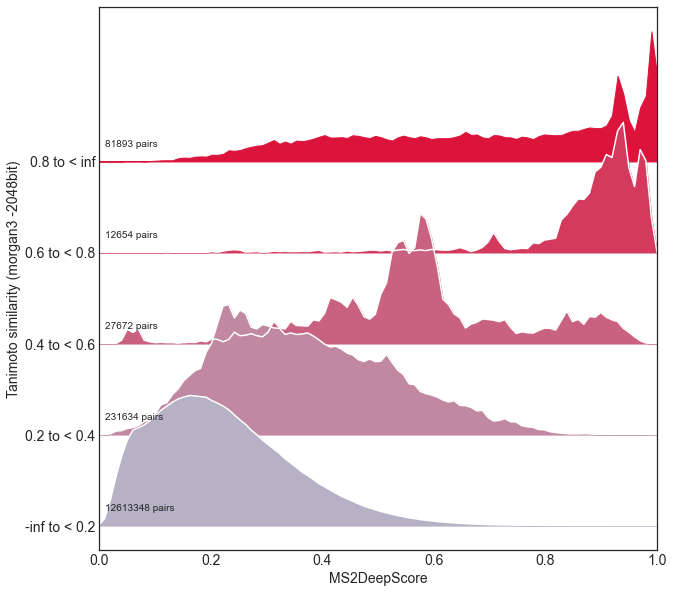

In [17]:
from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, similarities_test, n_bins=5, hist_resolution=100,
                          ref_score_name="Tanimoto similarity (morgan3 -2048bit)", compare_score_name="MS2DeepScore")

filename = os.path.join(path_models, "trained_models",
                        "histogram_20210402-125228_10k_800_800_200_morgan3.pdf")
plt.savefig(filename)

In [19]:
ref_score_bins = np.linspace(0,1.0, 11)
bin_content, bounds, rmses, maes = tanimoto_dependent_losses(similarities_test,
                                                             scores_ref, ref_score_bins)

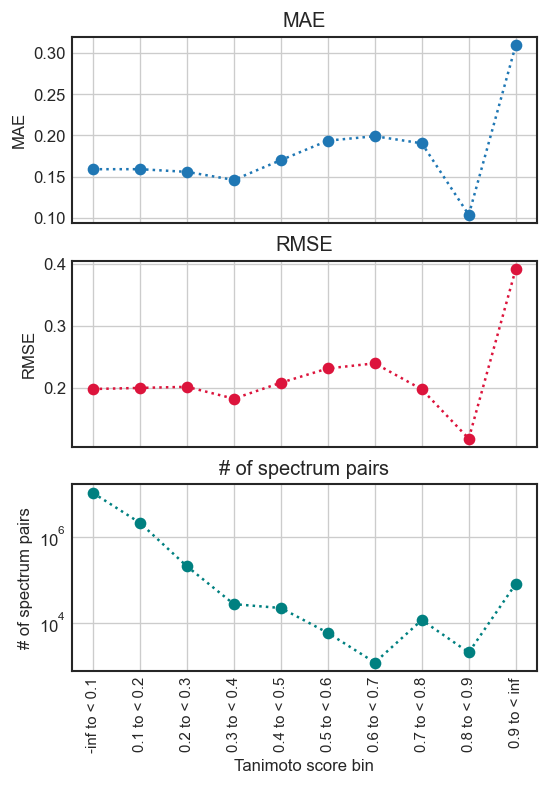

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(5, 7), dpi=120)
ax1.plot(np.arange(len(rmses)), maes, "o:")
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
#ax1.set_ylim(0)
ax1.grid(True)

ax2.plot(np.arange(len(rmses)), rmses, "o:", color="crimson")
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
ax2.grid(True)

ax3.plot(np.arange(len(rmses)), bin_content, "o:", color="teal")
ax3.set_title('# of spectrum pairs')
ax3.set_ylabel("# of spectrum pairs")
ax3.set_xlabel("Tanimoto score bin")
plt.yscale('log')
plt.xticks(np.arange(len(rmses)),
           [f"{a:.1f} to < {b:.1f}" for (a, b) in bounds], fontsize=9, rotation='vertical')
ax3.grid(True)
plt.savefig(os.path.join(path_models, "trained_models",
                        "tanimoto_bin_accuracy_20210402-125228_10k_800_800_200_morgan3.pdf"))

([0.007736056532169125,
  0.008028937503856949,
  0.009136025213601089,
  0.011007058983810996,
  0.014141459129979713,
  0.019205548825485082,
  0.02704280372119935,
  0.03940486601307048,
  0.05933130707397806,
  0.0912985256519611,
  0.14248977379315958,
  0.22447976761761404,
  0.3467809612067856,
  0.5072928042713263,
  0.6717892553798832,
  0.8052853312906932,
  0.8947269621369976,
  0.9397604003895192,
  0.9683763979946008,
  0.9951168081682481,
  1.0],
 [1.0,
  0.9999601256043463,
  0.9981458406021034,
  0.9954543188954792,
  0.9875193141603947,
  0.9721078602402432,
  0.9448736480087724,
  0.9077904600508399,
  0.8653641030753128,
  0.8162587848277925,
  0.7677715197129044,
  0.7195235009719384,
  0.671454917011414,
  0.6251208692618252,
  0.5747794447490405,
  0.5239994018840652,
  0.47513333001046704,
  0.41366694911030255,
  0.3254049743308578,
  0.1787668843144096,
  6.978019239395903e-05])

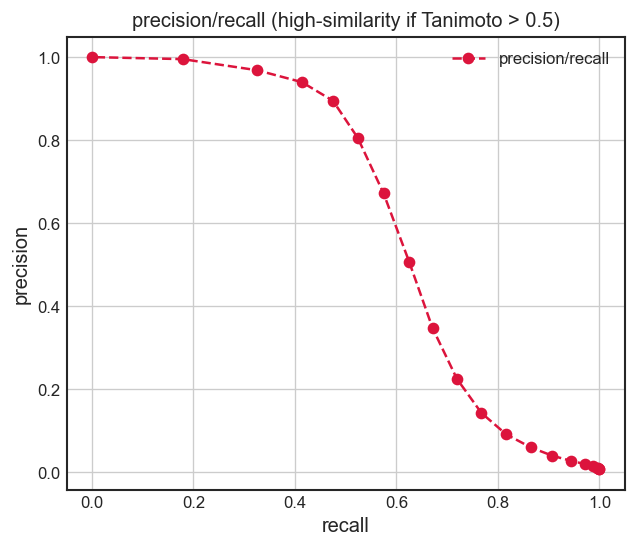

In [21]:
precision_recall_plot(similarities_test, scores_ref, high_sim_threshold=0.5, n_bins=20)

## Import pretrained model (20210403-190128_10k_500_500_200_morgan3.hdf5)

In [6]:
# import spectrum binner
outfile = os.path.join(path_data, 'GNPS_all',
                       'ALL_GNPS_positive_training_spectrum_binner_210301_10k.pickle')
with open(outfile, 'rb') as file:
    spectrum_binner = pickle.load(file)  

In [47]:
import tensorflow as tf
from tensorflow.keras.models import load_model as load_keras_model
keras_model_file = os.path.join(path_models, "trained_models", "20210403-190128_10k_500_500_200_morgan3.hdf5")
keras_model = load_keras_model(keras_model_file)

In [48]:
model = SiameseModel(spectrum_binner, keras_model=keras_model)

In [49]:
model.base.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 9948)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 500)               4974500   
_________________________________________________________________
normalization1 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dropout1 (Dropout)           (None, 500)               0         
_________________________________________________________________
dense2 (Dense)               (None, 500)               250500    
_________________________________________________________________
normalization2 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dropout2 (Dropout)           (None, 500)               0      

## Predict Tanimoto scores

In [50]:
from ms2deepscore import MS2DeepScore
similarity_score = MS2DeepScore(model)

In [51]:
similarities_test = similarity_score.matrix(spectrums_test, spectrums_test, is_symmetric=True)

Spectrum binning: 100%|█| 3601/3601 [00:26<00:00, 135
Create BinnedSpectrum instances: 100%|█| 3601/3601 [0
Calculating vectors of reference spectrums: 100%|█| 3


In [52]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_test_20210403-190128_10k_500_500_200_morgan3.npy")
np.save(predictions_file, similarities_test)

### Alternative (e.g. for re-runs): load pre-computed scores

In [4]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_test_20210403-190128_10k_500_500_200_morgan3.npy")
similarities_test = np.load(predictions_file)

In [6]:
inchikey_idx_test = np.zeros(len(spectrums_test))
for i, spec in enumerate(spectrums_test):
    inchikey_idx_test[i] = np.where(tanimoto_df.index.values == spec.get("inchikey")[:14])[0]

inchikey_idx_test = inchikey_idx_test.astype("int")

In [7]:
np.unique(inchikey_idx_test).shape

(500,)

In [8]:
scores_ref = tanimoto_df.values[np.ix_(inchikey_idx_test[:], inchikey_idx_test[:])].copy()

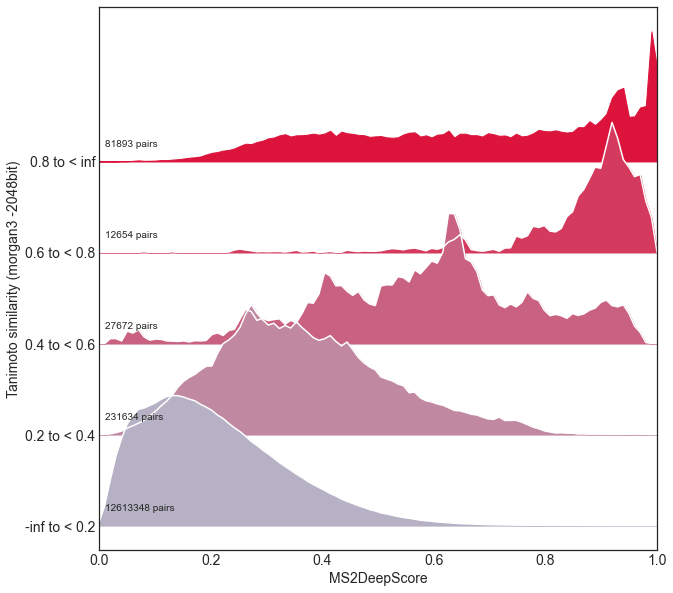

In [56]:
from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, similarities_test, n_bins=5, hist_resolution=100,
                          ref_score_name="Tanimoto similarity (morgan3 -2048bit)", compare_score_name="MS2DeepScore")

filename = os.path.join(path_models, "trained_models",
                        "histogram_20210403-190128_10k_500_500_200_morgan3.pdf")
plt.savefig(filename)

In [9]:
ref_score_bins = np.linspace(0,1.0, 11)
bin_content, bounds, rmses, maes = tanimoto_dependent_losses(similarities_test,
                                                             scores_ref, ref_score_bins)

In [10]:
labels = []
labels.append("Tanimoto (morgan3, 2048bits)")
rmses_collection = []
rmses_collection.append(rmses)
maes_collection = []
maes_collection.append(maes)

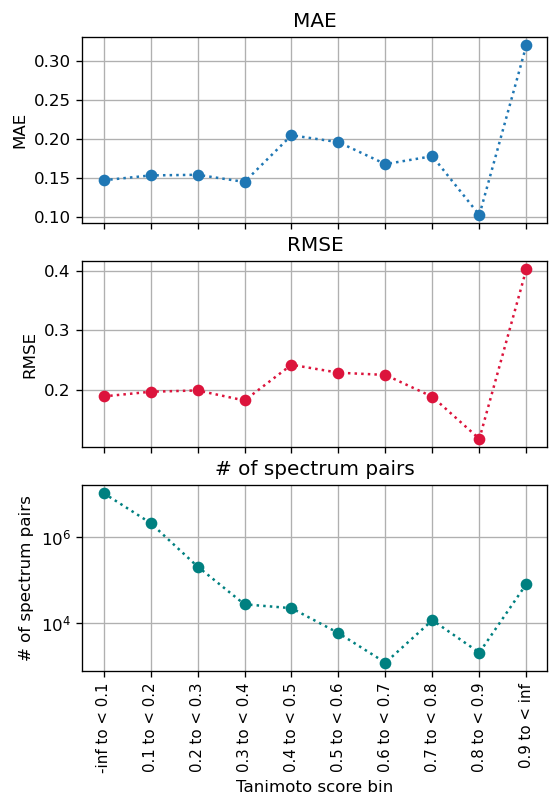

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(5, 7), dpi=120)
ax1.plot(np.arange(len(rmses)), maes, "o:")
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
#ax1.set_ylim(0)
ax1.grid(True)

ax2.plot(np.arange(len(rmses)), rmses, "o:", color="crimson")
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
ax2.grid(True)

ax3.plot(np.arange(len(rmses)), bin_content, "o:", color="teal")
ax3.set_title('# of spectrum pairs')
ax3.set_ylabel("# of spectrum pairs")
ax3.set_xlabel("Tanimoto score bin")
plt.yscale('log')
plt.xticks(np.arange(len(rmses)),
           [f"{a:.1f} to < {b:.1f}" for (a, b) in bounds], fontsize=9, rotation='vertical')
ax3.grid(True)
plt.savefig(os.path.join(path_models, "trained_models",
                        "tanimoto_bin_accuracy_20210403-190128_10k_500_500_200_morgan3.pdf"))

# Load Tanimoto scores (=labels) THIS TIME: using morgan2 fingerprints

In [11]:
filename = os.path.join(path_data, 'ALL_GNPS_210125_positive_morgan2_tanimoto_scores.pickle')
tanimoto_df = pd.read_pickle(filename)
tanimoto_df.head()

,JJGYRVZPUJUFTR,CSVWQRLFFUNUND,PXWNBAGCFUDYBE,DFJVUWAHTQPQCV,PNOLBYVRLYUCIC,HBNPJJILLOYFJU,IVKGLRZLTNXWKF,WHZAJDSPQDCUBB,LFVSQVHIKFDYFI,LBBJNGFCXDOYMQ,...,NBWDKCDWCBQNQQ,WKHWTIZYRUWECB,HYIFFZAQXPUEAU,GYOZYWVXFNDGLU,YNDYKPRNFWPPFU,IYODIJVWGPRBGQ,XHCADAYNFIFUHF,OJAGBDHRHPCDLN,POUZLUJYBWGJJO,JAYJEXYYCNLGOQ
JJGYRVZPUJUFTR,1.000000,0.075000,0.102941,0.070588,0.107843,0.134615,0.097561,0.080460,0.112500,0.088235,...,0.101124,0.132353,0.115942,0.139241,0.083333,0.027397,0.086420,0.122449,0.089552,0.125000
CSVWQRLFFUNUND,0.075000,1.000000,0.065421,0.083333,0.070423,0.113475,0.066116,0.090164,0.075630,0.076190,...,0.104839,0.026549,0.026549,0.093220,0.026316,0.096154,0.058333,0.087591,0.037037,0.064516
PXWNBAGCFUDYBE,0.102941,0.065421,1.000000,0.101449,0.101124,0.119565,0.171875,0.128571,0.121212,0.092593,...,0.169014,0.169811,0.107143,0.086957,0.105263,0.090909,0.106061,0.104651,0.160000,0.057143
DFJVUWAHTQPQCV,0.070588,0.083333,0.101449,1.000000,0.075472,0.081818,0.123457,0.067416,0.097561,0.071429,...,0.087912,0.068493,0.083333,0.083333,0.053333,0.055556,0.112500,0.099010,0.104478,0.067227
PNOLBYVRLYUCIC,0.107843,0.070423,0.101124,0.075472,1.000000,0.128000,0.130000,0.093458,0.120000,0.127907,...,0.287234,0.098901,0.075269,0.177083,0.086022,0.065217,0.290698,0.242991,0.090909,0.103704


## Import test data

In [3]:
import pickle
outfile = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_test_split_210301.pickle')
with open(outfile, 'rb') as file:
    spectrums_test = pickle.load(file)

print(f"{len(spectrums_test)} spectrums in test data.")

3601 spectrums in test data.


## Import pretrained model (ms2ds_210301_noDO1st_morgan2_10k_500_500_200.hdf5)

In [4]:
# import spectrum binner
outfile = os.path.join(path_data, 'GNPS_all',
                       'ALL_GNPS_positive_training_spectrum_binner_210301_10k.pickle')
with open(outfile, 'rb') as file:
    spectrum_binner = pickle.load(file)  

In [23]:
import tensorflow as tf
from tensorflow.keras.models import load_model as load_keras_model
keras_model_file = os.path.join(path_models, "trained_models", "ms2ds_210301_noDO1st_morgan2_10k_500_500_200.hdf5")
keras_model = load_keras_model(keras_model_file)

In [24]:
model = SiameseModel(spectrum_binner, keras_model=keras_model)

In [18]:
#model.save("ms2ds_......_earlystopping.hdf5")

In [25]:
model.base.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 9948)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 500)               4974500   
_________________________________________________________________
normalization1 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dense2 (Dense)               (None, 500)               250500    
_________________________________________________________________
normalization2 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dropout2 (Dropout)           (None, 500)               0         
_________________________________________________________________
embedding (Dense)            (None, 200)               100200 

## Predict Tanimoto scores

In [26]:
from ms2deepscore import MS2DeepScore
similarity_score = MS2DeepScore(model)

In [27]:
similarities_test = similarity_score.matrix(spectrums_test, spectrums_test, is_symmetric=True)

Calculating vectors of reference spectrums: 100%|██████████████████████████████████| 3601/3601 [04:18<00:00, 13.96it/s]


In [28]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_test_ms2ds_210301_noDO1st_morgan2_10k_500_500_200.npy")
np.save(predictions_file, similarities_test)

In [12]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_test_ms2ds_210301_noDO1st_morgan2_10k_500_500_200.npy")
similarities_test = np.load(predictions_file)

In [13]:
inchikey_idx_test = np.zeros(len(spectrums_test))
for i, spec in enumerate(spectrums_test):
    inchikey_idx_test[i] = np.where(tanimoto_df.index.values == spec.get("inchikey")[:14])[0]

inchikey_idx_test = inchikey_idx_test.astype("int")

In [25]:
np.unique(inchikey_idx_test).shape

(500,)

In [14]:
scores_ref_morgan2 = tanimoto_df.values[np.ix_(inchikey_idx_test[:], inchikey_idx_test[:])].copy()

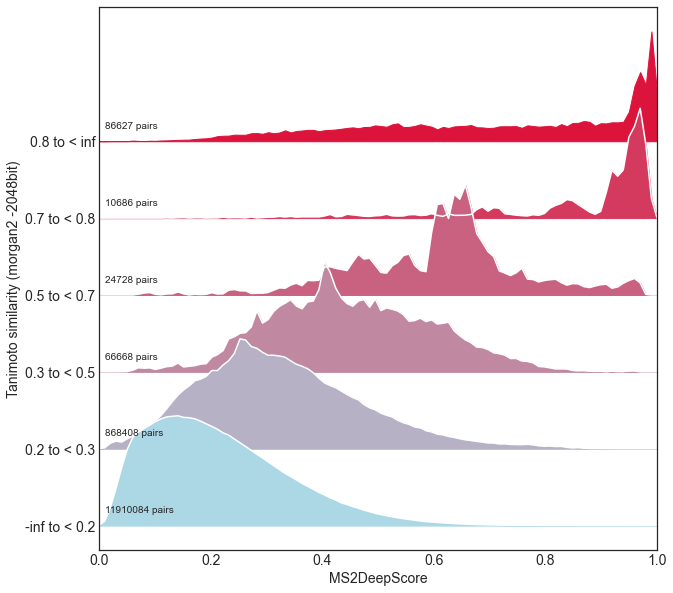

In [39]:
from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref_morgan2, similarities_test, n_bins=6, hist_resolution=100,
                       ref_score_name="Tanimoto similarity (morgan2 -2048bit)", compare_score_name="MS2DeepScore")

filename = os.path.join(path_models, "trained_models",
                        "histogram_ms2ds_210301_noDO1st_morgan2_10k_500_500_200.pdf")
plt.savefig(filename)

In [15]:
ref_score_bins = np.linspace(0,1.0, 11)
bin_content, bounds, rmses, maes = tanimoto_dependent_losses(similarities_test,
                                                             scores_ref_morgan2, ref_score_bins)

In [16]:
labels.append("Tanimoto (morgan2, 2048bits)")
rmses_collection.append(rmses)
maes_collection.append(maes)

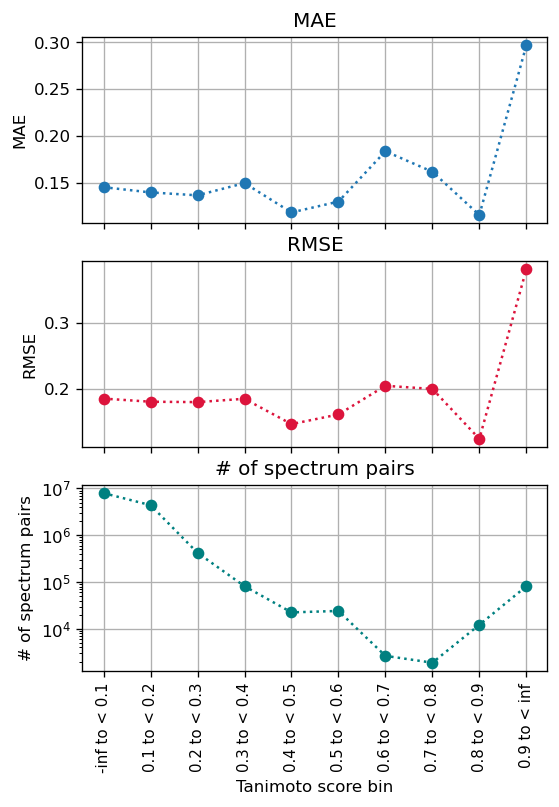

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(5, 7), dpi=120)
ax1.plot(np.arange(len(rmses)), maes, "o:")
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
#ax1.set_ylim(0)
ax1.grid(True)

ax2.plot(np.arange(len(rmses)), rmses, "o:", color="crimson")
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
ax2.grid(True)

ax3.plot(np.arange(len(rmses)), bin_content, "o:", color="teal")
ax3.set_title('# of spectrum pairs')
ax3.set_ylabel("# of spectrum pairs")
ax3.set_xlabel("Tanimoto score bin")
plt.yscale('log')
plt.xticks(np.arange(len(rmses)),
           [f"{a:.1f} to < {b:.1f}" for (a, b) in bounds], fontsize=9, rotation='vertical')
ax3.grid(True)
plt.savefig(os.path.join(path_models, "trained_models",
                        "tanimoto_bin_accuracy_ms2ds_210301_noDO1st_morgan2_10k_500_500_200.pdf"))

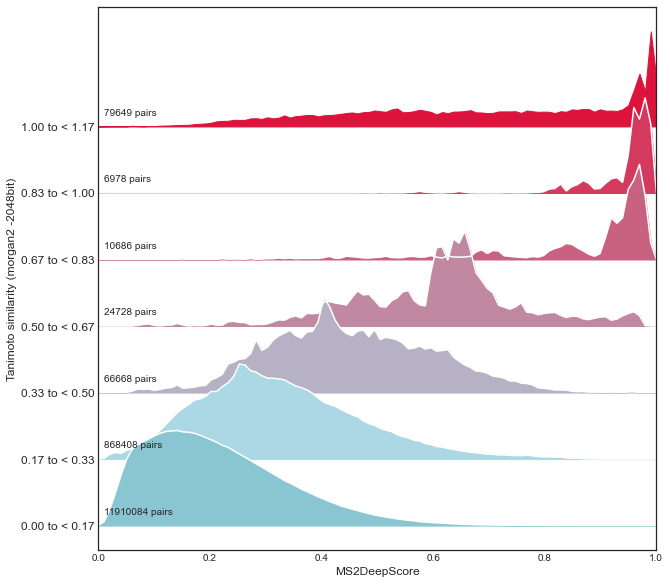

In [20]:
from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, similarities_test, n_bins=6, hist_resolution=100,
                          ref_score_name="Tanimoto similarity (morgan2 -2048bit)", compare_score_name="MS2DeepScore")

filename = os.path.join(path_models, "trained_models",
                        "histogram_ms2ds_210301_noDO1st_morgan2_10k_500_500_200.pdf")
plt.savefig(filename)

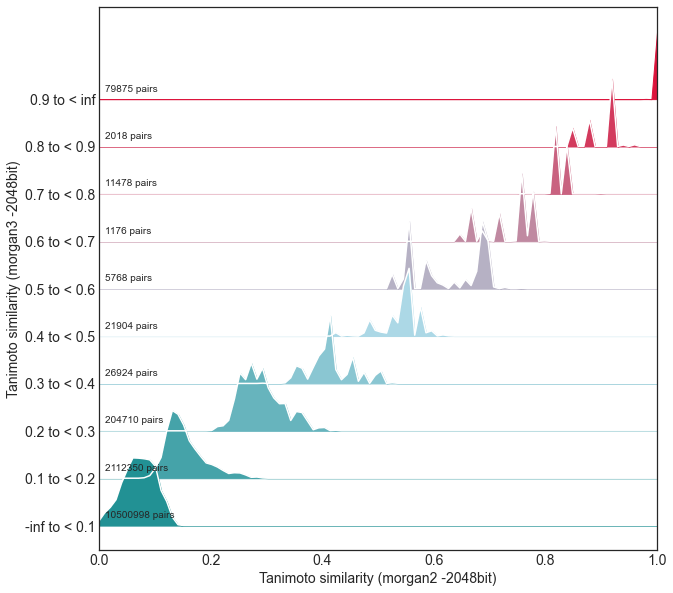

In [45]:
create_histograms_plot(scores_ref, scores_ref_morgan2, n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity (morgan3 -2048bit)", compare_score_name="Tanimoto similarity (morgan2 -2048bit)")


# Load Tanimoto scores (=labels) THIS TIME: using DICE (morgan2 fingerprints)

In [17]:
filename = os.path.join(path_data, 'ALL_GNPS_210125_morgan2_2048_dice_scores.pickle')
dice_df = pd.read_pickle(filename)
dice_df.head()

,JJGYRVZPUJUFTR,CSVWQRLFFUNUND,PXWNBAGCFUDYBE,DFJVUWAHTQPQCV,PNOLBYVRLYUCIC,HBNPJJILLOYFJU,IVKGLRZLTNXWKF,WHZAJDSPQDCUBB,LFVSQVHIKFDYFI,LBBJNGFCXDOYMQ,...,NBWDKCDWCBQNQQ,WKHWTIZYRUWECB,HYIFFZAQXPUEAU,GYOZYWVXFNDGLU,YNDYKPRNFWPPFU,IYODIJVWGPRBGQ,XHCADAYNFIFUHF,OJAGBDHRHPCDLN,POUZLUJYBWGJJO,JAYJEXYYCNLGOQ
JJGYRVZPUJUFTR,1.000000,0.139535,0.186667,0.131868,0.194690,0.237288,0.177778,0.148936,0.202247,0.162162,...,0.183673,0.233766,0.207792,0.244444,0.153846,0.053333,0.159091,0.218182,0.164384,0.222222
CSVWQRLFFUNUND,0.139535,1.000000,0.122807,0.153846,0.131579,0.203822,0.124031,0.165414,0.140625,0.141593,...,0.189781,0.051724,0.051724,0.170543,0.051282,0.175439,0.110236,0.161074,0.071429,0.121212
PXWNBAGCFUDYBE,0.186667,0.122807,1.000000,0.184211,0.183673,0.213592,0.293333,0.227848,0.216216,0.169492,...,0.289157,0.290323,0.193548,0.160000,0.190476,0.166667,0.191781,0.189474,0.275862,0.108108
DFJVUWAHTQPQCV,0.131868,0.153846,0.184211,1.000000,0.140351,0.151261,0.219780,0.126316,0.177778,0.133333,...,0.161616,0.128205,0.153846,0.153846,0.101266,0.105263,0.202247,0.180180,0.189189,0.125984
PNOLBYVRLYUCIC,0.194690,0.131579,0.183673,0.140351,1.000000,0.226950,0.230088,0.170940,0.214286,0.226804,...,0.446281,0.180000,0.140000,0.300885,0.158416,0.122449,0.450450,0.390977,0.166667,0.187919


## Import test data

In [3]:
import pickle
outfile = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_test_split_210301.pickle')
with open(outfile, 'rb') as file:
    spectrums_test = pickle.load(file)

print(f"{len(spectrums_test)} spectrums in test data.")

3601 spectrums in test data.


## Import pretrained model (20210403-215812_10k_500_500_200_morgan2dice.hdf5)

In [4]:
# import spectrum binner
outfile = os.path.join(path_data, 'GNPS_all',
                       'ALL_GNPS_positive_training_spectrum_binner_210301_10k.pickle')
with open(outfile, 'rb') as file:
    spectrum_binner = pickle.load(file)  

In [60]:
import tensorflow as tf
from tensorflow.keras.models import load_model as load_keras_model
keras_model_file = os.path.join(path_models, "trained_models", "20210403-215812_10k_500_500_200_morgan2dice.hdf5")
keras_model = load_keras_model(keras_model_file)

In [61]:
model = SiameseModel(spectrum_binner, keras_model=keras_model)

In [62]:
model.base.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 9948)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 500)               4974500   
_________________________________________________________________
normalization1 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dropout1 (Dropout)           (None, 500)               0         
_________________________________________________________________
dense2 (Dense)               (None, 500)               250500    
_________________________________________________________________
normalization2 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dropout2 (Dropout)           (None, 500)               0      

## Predict Tanimoto scores

In [63]:
from ms2deepscore import MS2DeepScore
similarity_score = MS2DeepScore(model)

In [64]:
similarities_test = similarity_score.matrix(spectrums_test, spectrums_test, is_symmetric=True)

Spectrum binning: 100%|█| 3601/3601 [00:26<00:00, 137
Create BinnedSpectrum instances: 100%|█| 3601/3601 [0
Calculating vectors of reference spectrums: 100%|█| 3


In [65]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_test_20210403-215812_10k_500_500_200_morgan2dice.npy")
np.save(predictions_file, similarities_test)

In [18]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_test_20210403-215812_10k_500_500_200_morgan2dice.npy")
similarities_test = np.load(predictions_file)

In [19]:
inchikey_idx_test = np.zeros(len(spectrums_test))
for i, spec in enumerate(spectrums_test):
    inchikey_idx_test[i] = np.where(tanimoto_df.index.values == spec.get("inchikey")[:14])[0]

inchikey_idx_test = inchikey_idx_test.astype("int")

In [33]:
np.unique(inchikey_idx_test).shape

(500,)

In [20]:
scores_ref_morgan2dice = dice_df.values[np.ix_(inchikey_idx_test[:], inchikey_idx_test[:])].copy()

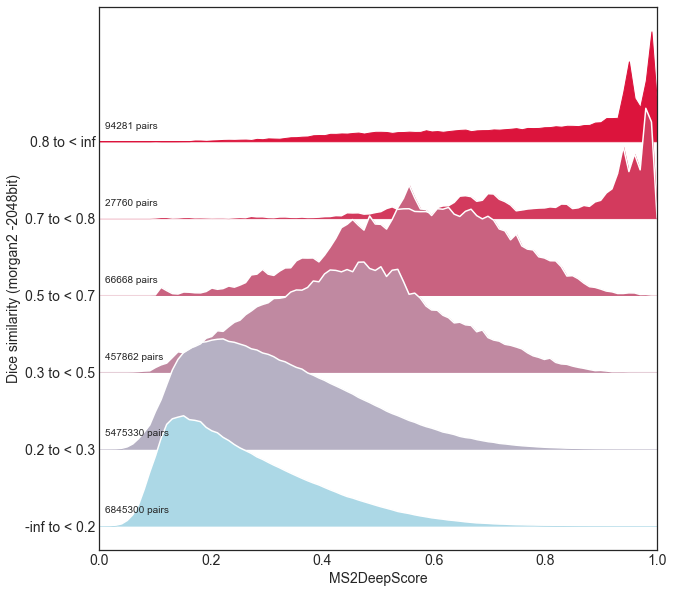

In [70]:
from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref_morgan2dice, similarities_test, n_bins=6, hist_resolution=100,
                       ref_score_name="Dice similarity (morgan2 - 2048bit)", compare_score_name="MS2DeepScore")

filename = os.path.join(path_models, "trained_models",
                        "histogram_20210403-215812_10k_500_500_200_morgan2dice.pdf")
plt.savefig(filename)

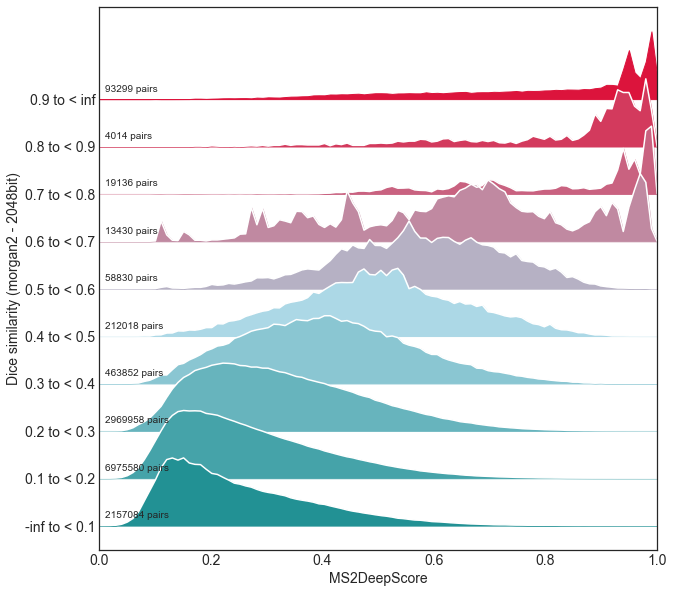

In [71]:
create_histograms_plot(scores_ref_morgan2dice, similarities_test, n_bins=10, hist_resolution=100,
                       ref_score_name="Dice similarity (morgan2 - 2048bit)", compare_score_name="MS2DeepScore")

In [21]:
ref_score_bins = np.linspace(0,1.0, 11)
bin_content, bounds, rmses, maes = tanimoto_dependent_losses(similarities_test,
                                                             scores_ref_morgan2dice, ref_score_bins)

In [22]:
labels.append("Dice (morgan2, 2048bits)")
rmses_collection.append(rmses)
maes_collection.append(maes)

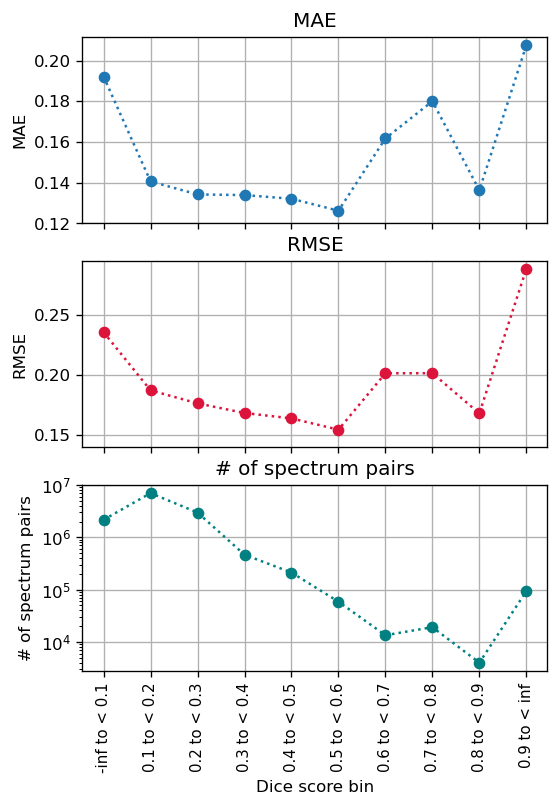

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(5, 7), dpi=120)
ax1.plot(np.arange(len(rmses)), maes, "o:")
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
ax1.set_ylim(0.12)
ax1.grid(True)

ax2.plot(np.arange(len(rmses)), rmses, "o:", color="crimson")
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
ax2.set_ylim(0.14)
ax2.grid(True)

ax3.plot(np.arange(len(rmses)), bin_content, "o:", color="teal")
ax3.set_title('# of spectrum pairs')
ax3.set_ylabel("# of spectrum pairs")
ax3.set_xlabel("Dice score bin")
plt.yscale('log')
plt.xticks(np.arange(len(rmses)),
           [f"{a:.1f} to < {b:.1f}" for (a, b) in bounds], fontsize=9, rotation='vertical')
ax3.grid(True)
plt.savefig(os.path.join(path_models, "trained_models",
                        "tanimoto_bin_accuracy_20210403-215812_10k_500_500_200_morgan2dice.pdf"))

# Comparison plot

### Load Tanimoto scores (=labels) THIS TIME: using rdkit fingerprints (2048bits)

In [5]:
filename = os.path.join(path_data, 'ALL_GNPS_210125_positive_tanimoto_scores.pickle')
tanimoto_df = pd.read_pickle(filename)
tanimoto_df.head()

,TXZUPPVCNIMVHW,DGYASNDHNSXGSL,JWYUFVNJZUSCSM,ZQXBVPNSSGEUCM,WIOKWEJDRXNVSH,NJMQSVWMCODQIP,VBFKEZGCUWHGSK,KJAYXCCGPDNITQ,NTAHMPNXQOYXSX,YALMHTJLWDGANA,...,DCPZWPYLSMMJKM,BFZHCUBIASXHPK,IYUIDAWSRJAFII,YMGXBGVMAOTRFZ,ZOVBJSDLILDXCH,ZBAVIUQLFUYWMT,LBZHBTVSBILXAE,FQXXSQDCDRQNQE,PKKTXAMCHLIVDS,HDDNZVWBRRAOGK
TXZUPPVCNIMVHW,1.000000,0.351169,0.097595,0.454490,0.232465,0.350913,0.220788,0.369819,0.553414,0.488411,...,0.245836,0.197547,0.319240,0.170619,0.419412,0.111339,0.502242,0.609171,0.456767,0.364198
DGYASNDHNSXGSL,0.351169,1.000000,0.095344,0.311426,0.266393,0.306679,0.187037,0.241550,0.352905,0.346228,...,0.239921,0.196926,0.248181,0.224319,0.328424,0.134894,0.371523,0.395833,0.325097,0.267617
JWYUFVNJZUSCSM,0.097595,0.095344,1.000000,0.087488,0.096552,0.089779,0.075710,0.078571,0.101093,0.111277,...,0.087171,0.076667,0.090069,0.086042,0.097539,0.082902,0.100224,0.097547,0.091977,0.091603
ZQXBVPNSSGEUCM,0.454490,0.311426,0.087488,1.000000,0.158416,0.403968,0.223629,0.428328,0.476427,0.356584,...,0.190833,0.303226,0.309870,0.151724,0.382889,0.200405,0.419784,0.455195,0.301105,0.505532
WIOKWEJDRXNVSH,0.232465,0.266393,0.096552,0.158416,1.000000,0.170429,0.115108,0.148259,0.213307,0.193948,...,0.235054,0.100985,0.156159,0.146067,0.189189,0.065600,0.208011,0.223117,0.272388,0.147978


## Import pretrained model (20210326-191145_Test_10k_500_500_200.hdf5)

In [6]:
# import spectrum binner
outfile = os.path.join(path_data, 'GNPS_all',
                       'ALL_GNPS_positive_training_spectrum_binner_210301_10k.pickle')
with open(outfile, 'rb') as file:
    spectrum_binner = pickle.load(file)  

In [40]:
import tensorflow as tf
from tensorflow.keras.models import load_model as load_keras_model
keras_model_file = os.path.join(path_models, "trained_models", "20210326-191145_Test_10k_500_500_200.hdf5")
keras_model = load_keras_model(keras_model_file)

In [41]:
model = SiameseModel(spectrum_binner, keras_model=keras_model)

## Predict Tanimoto scores

In [42]:
from ms2deepscore import MS2DeepScore
similarity_score = MS2DeepScore(model)

In [43]:
similarities_test = similarity_score.matrix(spectrums_test, spectrums_test, is_symmetric=True)

Spectrum binning: 100%|█| 3601/3601 [00:50<00:00, 70.
Create BinnedSpectrum instances: 100%|█| 3601/3601 [0
Calculating vectors of reference spectrums: 100%|█| 3


In [50]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_test_20210326-191145_Test_10k_500_500_200.npy")
np.save(predictions_file, similarities_test)

### Alternative (e.g. for re-runs): load pre-computed scores

In [24]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_test_20210326-191145_Test_10k_500_500_200.npy")
similarities_test = np.load(predictions_file)

In [25]:
inchikey_idx_test = np.zeros(len(spectrums_test))
for i, spec in enumerate(spectrums_test):
    inchikey_idx_test[i] = np.where(tanimoto_df.index.values == spec.get("inchikey")[:14])[0]

inchikey_idx_test = inchikey_idx_test.astype("int")

In [58]:
np.unique(inchikey_idx_test).shape

(500,)

In [26]:
scores_ref = tanimoto_df.values[np.ix_(inchikey_idx_test[:], inchikey_idx_test[:])].copy()

In [27]:
ref_score_bins = np.linspace(0,1.0, 11)
bin_content, bounds, rmses, maes = tanimoto_dependent_losses(similarities_test,
                                                             scores_ref, ref_score_bins)

In [28]:
labels.append("Tanimoto (daylight, 2048bits)")
rmses_collection.append(rmses)
maes_collection.append(maes)

In [30]:
pickle.dump(rmses_collection, open( "fingerprint_comparison_rmses_collection.pickle", "wb" ) )
pickle.dump(maes_collection, open( "fingerprint_comparison_maes_collection.pickle", "wb" ) )
pickle.dump(labels, open( "fingerprint_comparison_labels.pickle", "wb" ) )

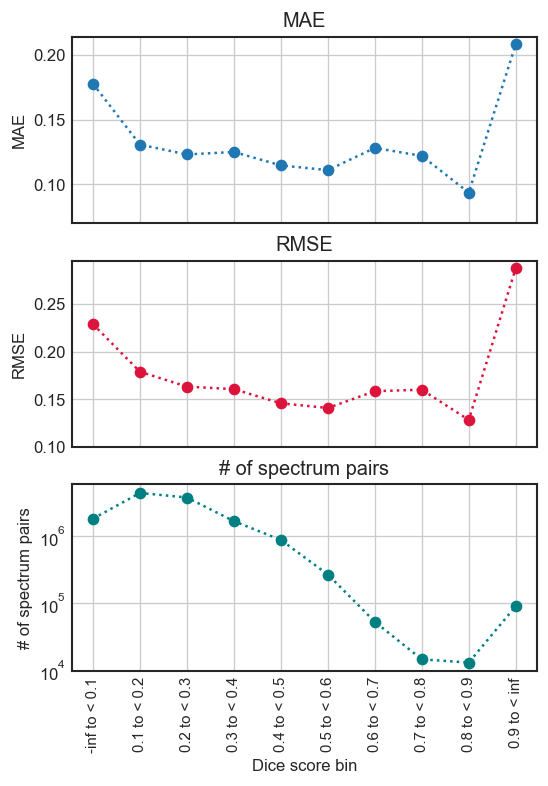

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(5, 7), dpi=120)
ax1.plot(np.arange(len(rmses)), maes, "o:")
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
ax1.set_ylim(0.07)
ax1.grid(True)

ax2.plot(np.arange(len(rmses)), rmses, "o:", color="crimson")
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
ax2.set_ylim(0.1)
ax2.grid(True)

ax3.plot(np.arange(len(rmses)), bin_content, "o:", color="teal")
ax3.set_title('# of spectrum pairs')
ax3.set_ylabel("# of spectrum pairs")
ax3.set_xlabel("Dice score bin")
plt.yscale('log')
plt.xticks(np.arange(len(rmses)),
           [f"{a:.1f} to < {b:.1f}" for (a, b) in bounds], fontsize=9, rotation='vertical')
ax3.grid(True)
plt.savefig(os.path.join(path_models, "trained_models",
                        "tanimoto_bin_accuracy_20210326-191145_Test_10k_500_500_200.pdf"))

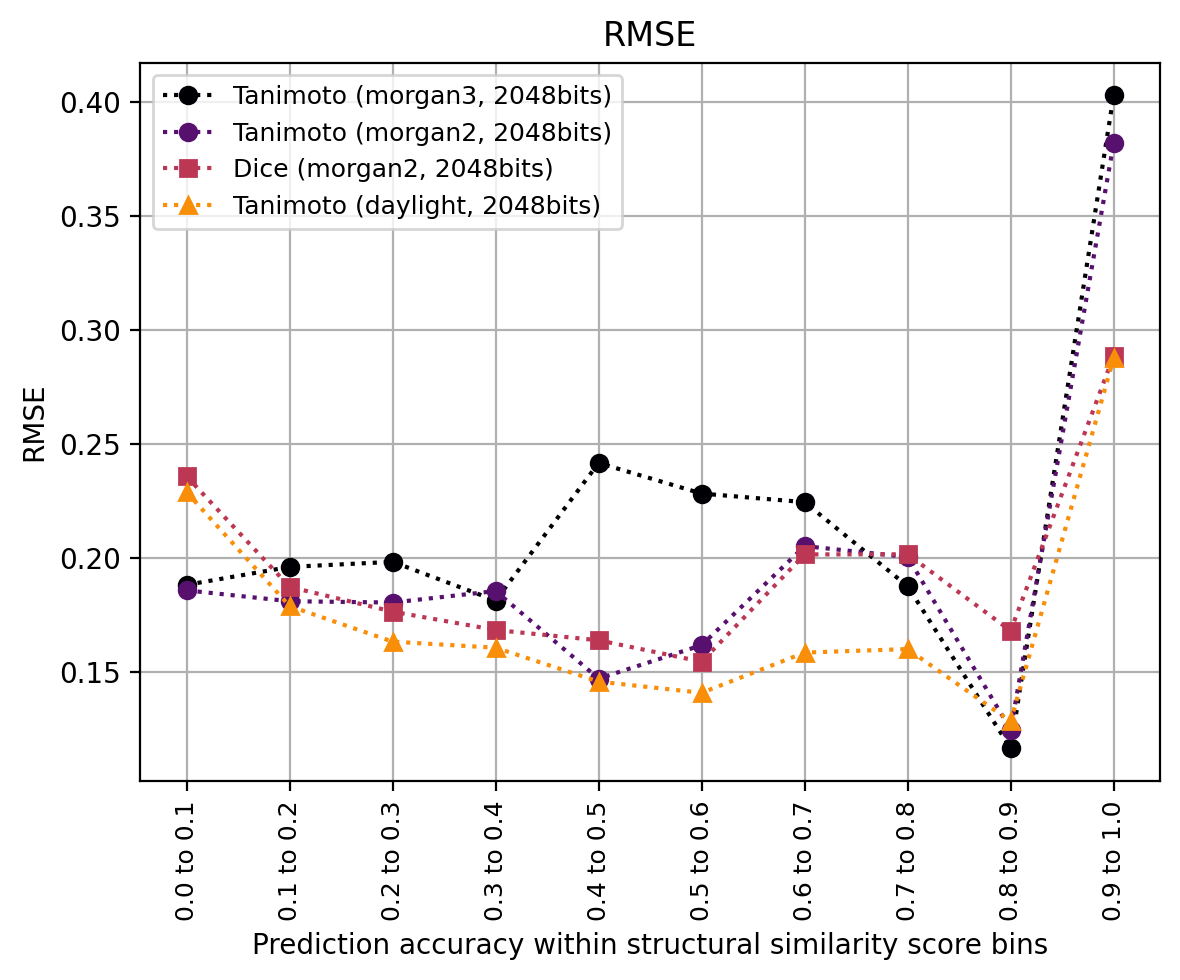

In [37]:
import matplotlib
cmap = matplotlib.cm.get_cmap('inferno')
markertypes = ["o", "o", "s", "^"]

bounds = [f"{a:.1f} to {a+0.1:.1f}" for a in ref_score_bins[:-1]]
N = len(labels)

fig, (ax2) = plt.subplots(1, 1, sharex=True, figsize=(6, 5), dpi=200)

for i in range(N):
    ax2.plot(ref_score_bins[:-1], rmses_collection[i], "o:", marker=markertypes[i],
             color=cmap(i/N), label=labels[i])
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
#ax2.set_ylim(0)
ax2.grid(True)
plt.legend(fontsize=9)
plt.xticks(ref_score_bins[:-1],
           bounds, fontsize=9, rotation='vertical')
plt.xlabel("Prediction accuracy within structural similarity score bins")
plt.tight_layout()
plt.savefig("comparison_fingerprints_tanimoto_dependent_accuracy.pdf")

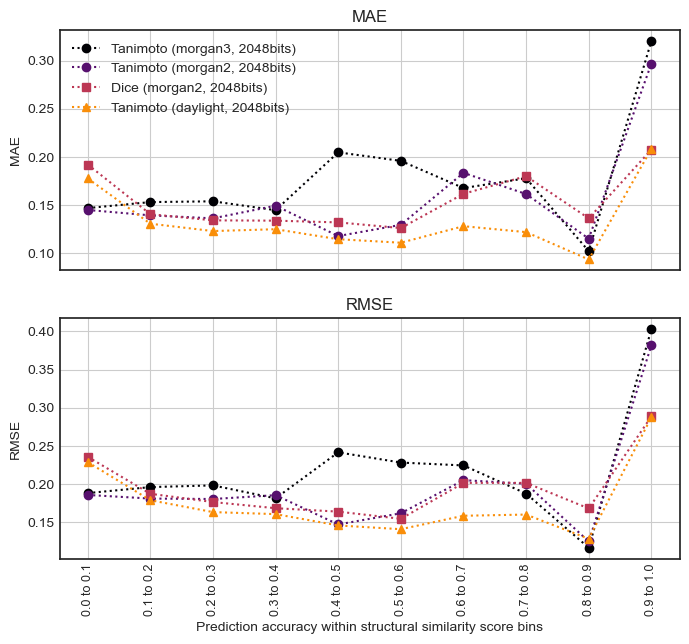

In [75]:
import matplotlib
cmap = matplotlib.cm.get_cmap('inferno')
markertypes = ["o", "o", "s", "^"]

bounds = [f"{a:.1f} to {a+0.1:.1f}" for a in ref_score_bins[:-1]]
N = len(labels)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7), dpi=100)
for i in range(N):
    ax1.plot(ref_score_bins[:-1], maes_collection[i], "o:", marker=markertypes[i],
             color=cmap(i/N), label=labels[i])
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
#ax1.set_ylim(0)
ax1.grid(True)
ax1.legend()

for i in range(N):
    ax2.plot(ref_score_bins[:-1], rmses_collection[i], "o:", marker=markertypes[i],
             color=cmap(i/N), label=labels[i])
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
#ax2.set_ylim(0)
ax2.grid(True)
plt.xticks(ref_score_bins[:-1],
           bounds, fontsize=9, rotation='vertical')
plt.xlabel("Prediction accuracy within structural similarity score bins")
plt.savefig("comparison_fingerprints_tanimoto_dependent_accuracy.pdf")

## Further plots as part of manuscript revision

In [8]:
inchikey_idx_test = np.zeros(len(spectrums_test))
for i, spec in enumerate(spectrums_test):
    inchikey_idx_test[i] = np.where(tanimoto_df.index.values == spec.get("inchikey")[:14])[0]

inchikey_idx_test = inchikey_idx_test.astype("int")

#scores_ref = tanimoto_df.values[np.ix_(inchikey_idx_test[:], inchikey_idx_test[:])].copy()

In [11]:
scores_dict = {"daylight": {"prediction": "predictions_test_20210326-191145_Test_10k_500_500_200.npy",
                           "scores": 'ALL_GNPS_210125_positive_tanimoto_scores.pickle'},
               "morgan3": {"prediction": "predictions_test_20210402-125228_10k_800_800_200_morgan3.npy",
                           "scores":'ALL_GNPS_210125_morgan3_2048_tanimoto_scores.pickle'},
               "morgan2": {"prediction": "predictions_test_ms2ds_210301_noDO1st_morgan2_10k_500_500_200.npy",
                           "scores":'ALL_GNPS_210125_positive_morgan2_tanimoto_scores.pickle'},
               "morgan2dice": {"prediction": "predictions_test_20210403-215812_10k_500_500_200_morgan2dice.npy",
                           "scores":'ALL_GNPS_210125_morgan2_2048_dice_scores.pickle'}}

In [15]:
from scipy.stats import pearsonr

for key, value in scores_dict.items():
    predictions_file = os.path.join(path_models, "trained_models", value["prediction"])
    similarities_test = np.load(predictions_file)
    filename = os.path.join(path_data, value["scores"])
    scores_df = pd.read_pickle(filename)
    
    # Get indices
    inchikey_idx_test = np.zeros(len(spectrums_test))
    for i, spec in enumerate(spectrums_test):
        inchikey_idx_test[i] = np.where(scores_df.index.values == spec.get("inchikey")[:14])[0]

    inchikey_idx_test = inchikey_idx_test.astype("int")
    
    scores_ref = scores_df.values[np.ix_(inchikey_idx_test[:], inchikey_idx_test[:])].copy()

    # calculate Pearson's correlation
    corr, _ = pearsonr(scores_ref.reshape(-1), similarities_test.reshape(-1))
    print(f"Pearsons correlation ({key}): {corr:.3f}")

Pearsons correlation (daylight): 0.549
Pearsons correlation (morgan3): 0.389
Pearsons correlation (morgan2): 0.428
Pearsons correlation (morgan2dice): 0.434


In [25]:
from scipy.stats import pearsonr

top_percentage = 2

print(f"Pearsons correlation for top {top_percentage}% of scores")
print(20 * "--")

for key, value in scores_dict.items():
    
    predictions_file = os.path.join(path_models, "trained_models", value["prediction"])
    similarities_test = np.load(predictions_file)
    filename = os.path.join(path_data, value["scores"])
    scores_df = pd.read_pickle(filename)
    
    # Get indices
    inchikey_idx_test = np.zeros(len(spectrums_test))
    for i, spec in enumerate(spectrums_test):
        inchikey_idx_test[i] = np.where(scores_df.index.values == spec.get("inchikey")[:14])[0]

    scores_ref = scores_df.values[np.ix_(inchikey_idx_test[:].astype(int),
                                         inchikey_idx_test[:].astype(int))].copy()

    threshold = np.percentile(scores_ref.reshape(-1), (100-top_percentage)) # top x% of scores
    idx = np.where(scores_ref.reshape(-1) >= threshold)

    # calculate Pearson's correlation
    corr, _ = pearsonr(scores_ref.reshape(-1)[idx], similarities_test.reshape(-1)[idx])
    print(f"Pearsons correlation ({key},  scores > {threshold:.4f}): {corr:.3f}")

Pearsons correlation for top 2% of scores
----------------------------------------
Pearsons correlation (daylight,  scores > 0.5472): 0.520
Pearsons correlation (morgan3,  scores > 0.2222): 0.579
Pearsons correlation (morgan2,  scores > 0.2892): 0.570
Pearsons correlation (morgan2dice,  scores > 0.4486): 0.518


In [22]:
from scipy.stats import pearsonr

top_percentage = 5

print(f"Pearsons correlation for top {top_percentage}% of scores")
print(20 * "--")

for key, value in scores_dict.items():
    
    predictions_file = os.path.join(path_models, "trained_models", value["prediction"])
    similarities_test = np.load(predictions_file)
    filename = os.path.join(path_data, value["scores"])
    scores_df = pd.read_pickle(filename)
    
    # Get indices
    inchikey_idx_test = np.zeros(len(spectrums_test))
    for i, spec in enumerate(spectrums_test):
        inchikey_idx_test[i] = np.where(scores_df.index.values == spec.get("inchikey")[:14])[0]

    scores_ref = scores_df.values[np.ix_(inchikey_idx_test[:].astype(int),
                                         inchikey_idx_test[:].astype(int))].copy()

    threshold = np.percentile(scores_ref.reshape(-1), (100-top_percentage)) # top x% of scores
    idx = np.where(scores_ref.reshape(-1) >= threshold)

    # calculate Pearson's correlation
    corr, _ = pearsonr(scores_ref.reshape(-1)[idx], similarities_test.reshape(-1)[idx])
    print(f"Pearsons correlation ({key},  scores > {threshold:.4f}): {corr:.3f}")

Pearsons correlation for top 5% of scores
----------------------------------------
Pearsons correlation (daylight,  scores > 0.4673): 0.542
Pearsons correlation (morgan3,  scores > 0.1518): 0.625
Pearsons correlation (morgan2,  scores > 0.1979): 0.629
Pearsons correlation (morgan2dice,  scores > 0.3304): 0.614


In [23]:
from scipy.stats import pearsonr

top_percentage = 20

print(f"Pearsons correlation for top {top_percentage}% of scores")
print(20 * "--")

for key, value in scores_dict.items():
    
    predictions_file = os.path.join(path_models, "trained_models", value["prediction"])
    similarities_test = np.load(predictions_file)
    filename = os.path.join(path_data, value["scores"])
    scores_df = pd.read_pickle(filename)
    
    # Get indices
    inchikey_idx_test = np.zeros(len(spectrums_test))
    for i, spec in enumerate(spectrums_test):
        inchikey_idx_test[i] = np.where(scores_df.index.values == spec.get("inchikey")[:14])[0]

    scores_ref = scores_df.values[np.ix_(inchikey_idx_test[:].astype(int),
                                         inchikey_idx_test[:].astype(int))].copy()

    threshold = np.percentile(scores_ref.reshape(-1), (100-top_percentage)) # top x% of scores
    idx = np.where(scores_ref.reshape(-1) >= threshold)

    # calculate Pearson's correlation
    corr, _ = pearsonr(scores_ref.reshape(-1)[idx], similarities_test.reshape(-1)[idx])
    print(f"Pearsons correlation ({key},  scores > {threshold:.4f}): {corr:.3f}")

Pearsons correlation for top 20% of scores
----------------------------------------
Pearsons correlation (daylight,  scores > 0.3193): 0.486
Pearsons correlation (morgan3,  scores > 0.0980): 0.540
Pearsons correlation (morgan2,  scores > 0.1250): 0.559
Pearsons correlation (morgan2dice,  scores > 0.2222): 0.557


In [24]:
from scipy.stats import pearsonr

top_percentage = 50

print(f"Pearsons correlation for top {top_percentage}% of scores")
print(20 * "--")

for key, value in scores_dict.items():
    
    predictions_file = os.path.join(path_models, "trained_models", value["prediction"])
    similarities_test = np.load(predictions_file)
    filename = os.path.join(path_data, value["scores"])
    scores_df = pd.read_pickle(filename)
    
    # Get indices
    inchikey_idx_test = np.zeros(len(spectrums_test))
    for i, spec in enumerate(spectrums_test):
        inchikey_idx_test[i] = np.where(scores_df.index.values == spec.get("inchikey")[:14])[0]

    scores_ref = scores_df.values[np.ix_(inchikey_idx_test[:].astype(int),
                                         inchikey_idx_test[:].astype(int))].copy()

    threshold = np.percentile(scores_ref.reshape(-1), (100-top_percentage)) # top x% of scores
    idx = np.where(scores_ref.reshape(-1) >= threshold)

    # calculate Pearson's correlation
    corr, _ = pearsonr(scores_ref.reshape(-1)[idx], similarities_test.reshape(-1)[idx])
    print(f"Pearsons correlation ({key},  scores > {threshold:.4f}): {corr:.3f}")

Pearsons correlation for top 50% of scores
----------------------------------------
Pearsons correlation (daylight,  scores > 0.2055): 0.522
Pearsons correlation (morgan3,  scores > 0.0698): 0.447
Pearsons correlation (morgan2,  scores > 0.0875): 0.481
Pearsons correlation (morgan2dice,  scores > 0.1609): 0.493
